In [84]:
import sys

%load_ext autoreload
%autoreload 2
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import pymongo
import re
import numpy as np
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
class MongoConfig():
    _host="localhost"
    _port=27017

    client = pymongo.MongoClient(f"{_host}:{_port}")
    
    readDB = client['MK_PROD_ALL']
    readBT = readDB['BACKTEST']
    readRAW = readDB['RAW']
    writeDB = client['MK_BT_RANK']
    write = writeDB['TF-old-v1']

In [233]:
ids = ['TNB MK Equity', 'YTLP MK Equity', 'SOLAR MK Equity', 'CYP MK Equity', 'JAK MK Equity', 'HSS MK Equity', 'RLEB MK Equity', 'STHB MK Equity', 'SUNVIEW MK Equity',
       'SAMAIDEN MK Equity', 'CITAGLB MK Equity', 'JSB MK Equity', 'MLM MK Equity', 'MNHLDG MK Equity', 'PEKAT MK Equity', 'UZMA MK Equity'
      ]

dq = MongoConfig.readRAW.find({'ID_BBG': {'$in': ids}, 'DATE': {'$gte': datetime(2022,1,1)}})
df = pd.DataFrame(dq)
df.columns = df.columns.str.lower()

In [233]:
ids = ['TNB MK Equity', 'YTLP MK Equity', 'SOLAR MK Equity', 'CYP MK Equity', 'JAK MK Equity', 'HSS MK Equity', 'RLEB MK Equity', 'STHB MK Equity', 'SUNVIEW MK Equity',
       'SAMAIDEN MK Equity', 'CITAGLB MK Equity', 'JSB MK Equity', 'MLM MK Equity', 'MNHLDG MK Equity', 'PEKAT MK Equity', 'UZMA MK Equity'
      ]

dq = MongoConfig.readRAW.find({'ID_BBG': {'$in': ids}, 'DATE': {'$gte': datetime(2022,1,1)}})
df = pd.DataFrame(dq)
df.columns = df.columns.str.lower()

In [234]:
df = df[['date','id_bbg', 'name', 'px_last', 'px_last_1', 'cur_mkt_cap']].copy()

In [205]:
df.to_csv('green_index_data.csv', index=False)

In [236]:
df['id_bbg'].unique()

array(['STHB MK Equity', 'JSB MK Equity', 'TNB MK Equity',
       'YTLP MK Equity', 'JAK MK Equity', 'CITAGLB MK Equity',
       'UZMA MK Equity', 'CYP MK Equity', 'SOLAR MK Equity',
       'RLEB MK Equity', 'PEKAT MK Equity', 'SAMAIDEN MK Equity',
       'HSS MK Equity', 'MNHLDG MK Equity'], dtype=object)

# streamlit

In [223]:
sdf = df[df['date']==df['date'].max()].sort_values(['cur_mkt_cap'], ascending=False)[['id_bbg','name','cur_mkt_cap']]
sdf = sdf.reset_index(drop=True)

In [224]:
sdf

,id_bbg,name,cur_mkt_cap
0,TNB MK Equity,Tenaga Nasional Bhd,5.324227e+10
1,YTLP MK Equity,YTL Power International Bhd,9.641564e+09
2,SOLAR MK Equity,Solarvest Holdings Bhd,7.476604e+08
3,CITAGLB MK Equity,Citaglobal Bhd,5.720318e+08
4,CYP MK Equity,Cypark Resources Bhd,5.514282e+08
5,JAK MK Equity,JAKS Resources Bhd,3.883836e+08
6,SAMAIDEN MK Equity,Samaiden Group Bhd,3.602726e+08
7,JSB MK Equity,Jentayu Sustainables Bhd,3.390737e+08
8,HSS MK Equity,HSS Engineers Bhd,2.678293e+08
9,PEKAT MK Equity,Pekat Group Bhd,2.547624e+08


In [225]:
df = pd.read_csv('green_index_data.csv')

In [229]:
df = df.sort_values(['date', 'id_bbg'])
df['log_market_cap'] = np.log(df['cur_mkt_cap'])
df['total_log_market_cap'] = df.groupby(['date'])['log_market_cap'].transform('sum')
df['return'] = df['px_last']/df['px_last_1']-1
df['weight'] = np.log(df['log_market_cap'])/np.log(df['total_log_market_cap'])
df['weighted_return']= (df['return']*df['weight'])+1
df['cum_return'] = df.groupby(['id_bbg'])['weighted_return'].cumprod()

In [230]:
tdf = df.pivot_table(values='cum_return',index='date', columns='id_bbg')
tdf['green_index'] = tdf.mean(axis=1)

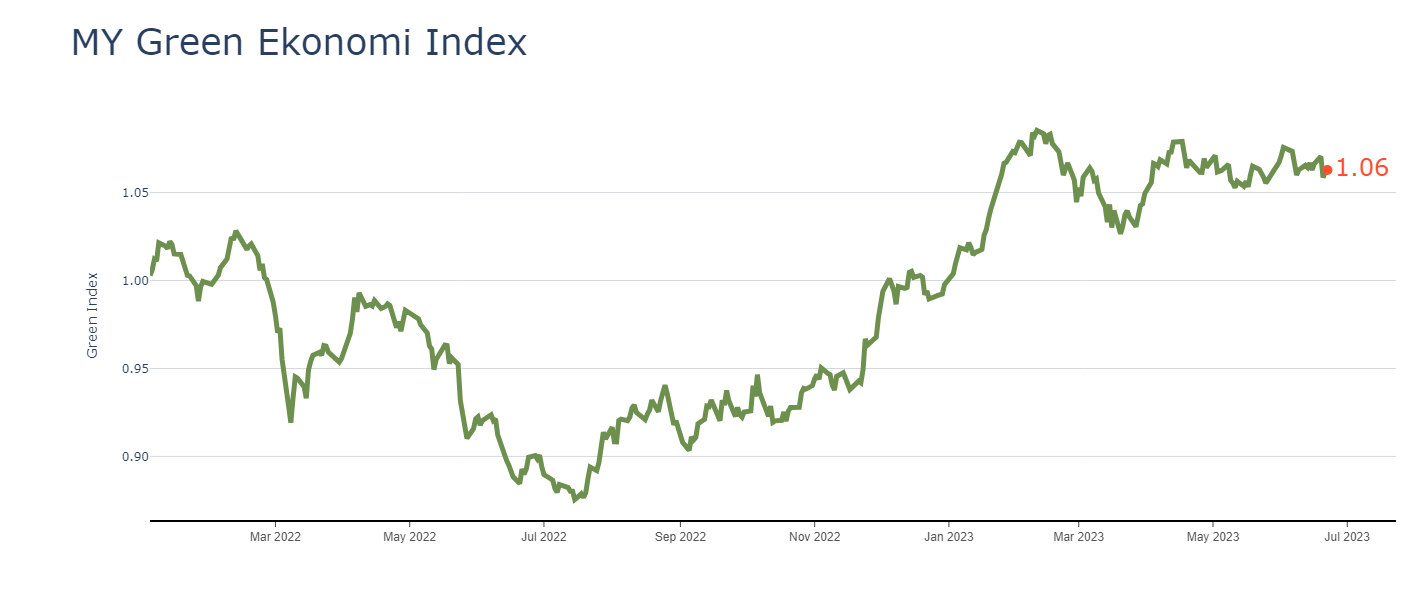

In [232]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_scatter(x=tdf.index, y = tdf['green_index'],
                mode = 'lines',
                line = dict(color='#6d904f', width=5),
                showlegend=False)

fig.add_scatter(x = [fig.data[0].x[-1]], y = [fig.data[0].y[-1]],
                     mode = 'markers + text',
                     marker = {'color':'#fc4f30', 'size':10},
                     showlegend = False,
                     text = ['{:,.2f}'.format(fig.data[0].y[-1])],
                     textfont=dict(color='#fc4f30', size=24),
                     textposition='middle right')

fig.update_layout(
        title=dict(text='MY Green Ekonomi Index', font_size=36),
        width=1200, height=600,
            xaxis=dict(
                autorange=True,
                showline=True,
                showgrid=False,
                showticklabels=True,
                automargin=True,
                linecolor='black',
                linewidth=2,
                ticks='outside',
                tickfont=dict(
                    family='Arial',
                    size=12,
                    color='rgb(82, 82, 82)',
                ),
            ),
            yaxis=dict(
                title='Green Index',
                gridcolor='#D5D8DC',
                tickformat='.2f',
                showgrid=True,
                zeroline=False,
                showline=False,
                showticklabels=True,
            ),
            autosize=True,
            margin=dict(
                autoexpand=True,
                l=150,
                r=10,
                t=110,
                #pad=200,
            ),
            showlegend=True,
            legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.2,
            xanchor="left",
            ),
            plot_bgcolor='white')
fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True
fig.show()

<AxesSubplot:xlabel='date'>

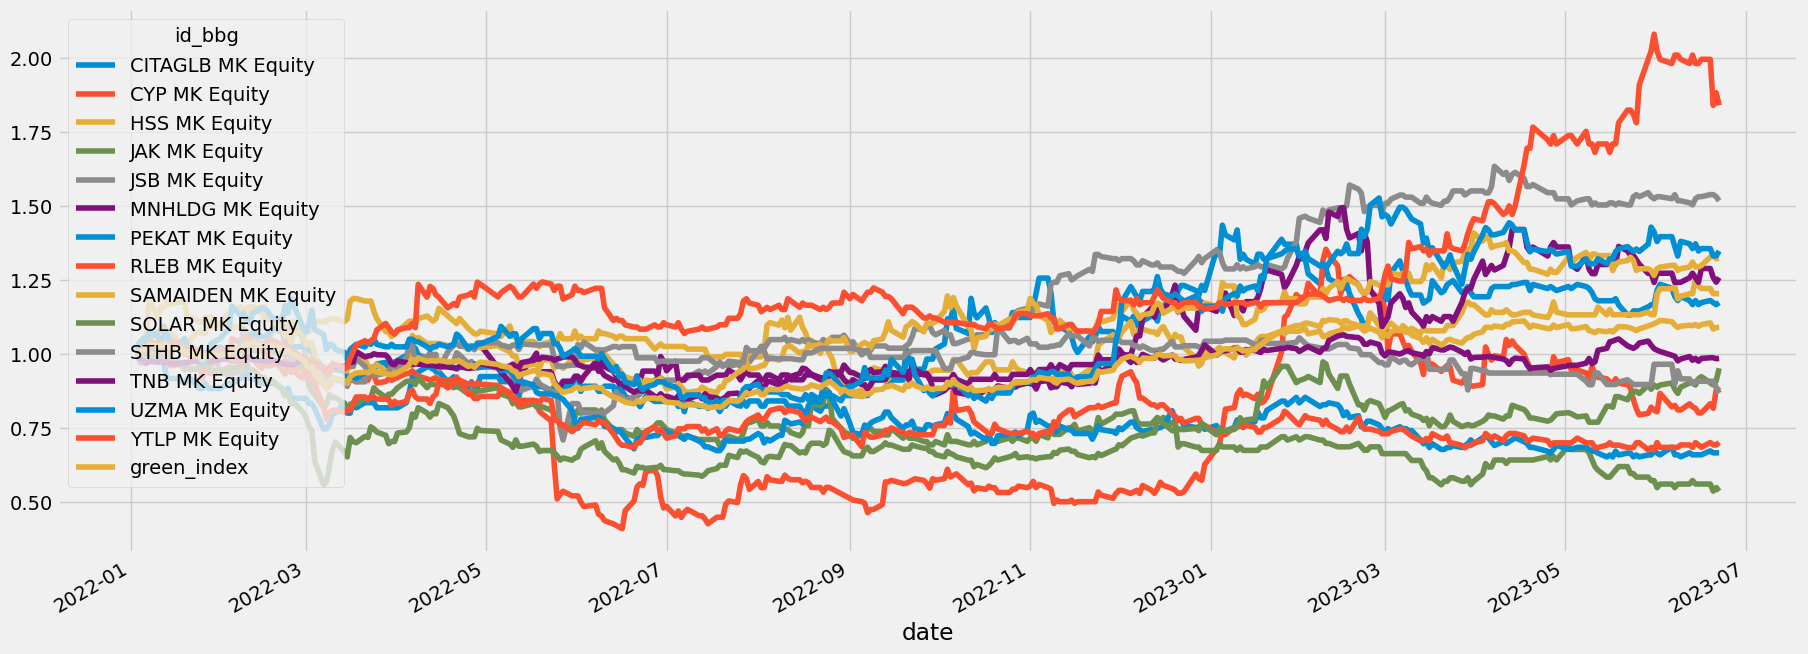

In [199]:
fig, ax1 = plt.subplots(figsize=(20,8))
tdf = df.pivot_table(values='cum_return',index='date', columns='id_bbg')
tdf['green_index'] = tdf.mean(axis=1)
tdf.plot(ax=ax1)

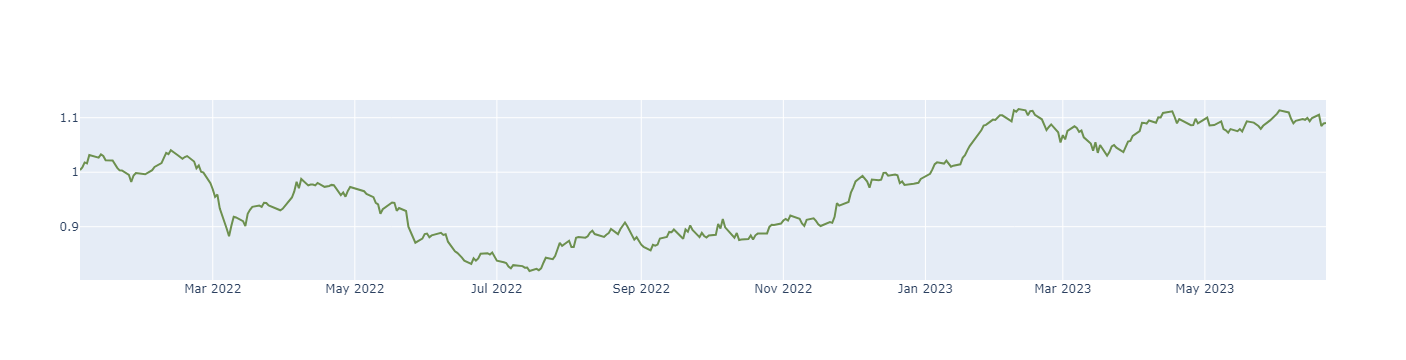

In [200]:
fig = go.Figure()
fig.add_scatter(x=tdf.index, y = tdf['green_index'],
                mode = 'lines',
                #text = '{:.2f}'.format(dd.y[-1]),
                textfont = dict(color='#6d904f'),
                textposition='top right',
                marker = dict(color = '#6d904f', size = 1, opacity=1),
                #legendgroup = dd.name,
                showlegend=False)

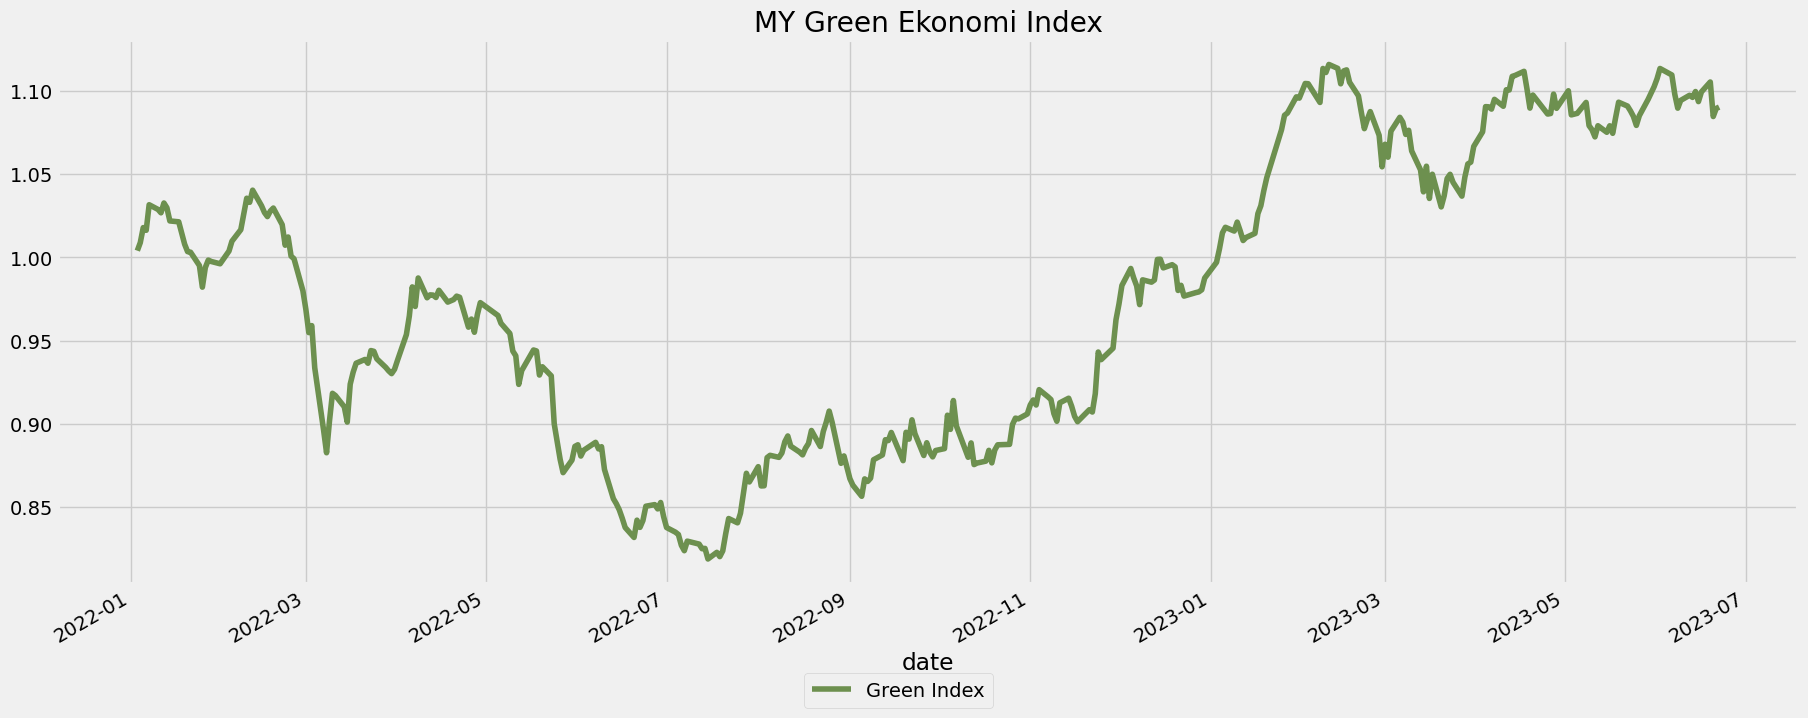

In [160]:
fig, ax1 = plt.subplots(figsize=(20,8))
#ax2 = ax1.twinx()
tdf['green_index'].plot(ax=ax1, color='#6d904f', label='Green Index')
#tdf['TNB MK Equity'].plot(ax=ax2, color='blue')
plt.title('MY Green Ekonomi Index')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1), fancybox=True, shadow=False, ncol=5)

<AxesSubplot:xlabel='date'>

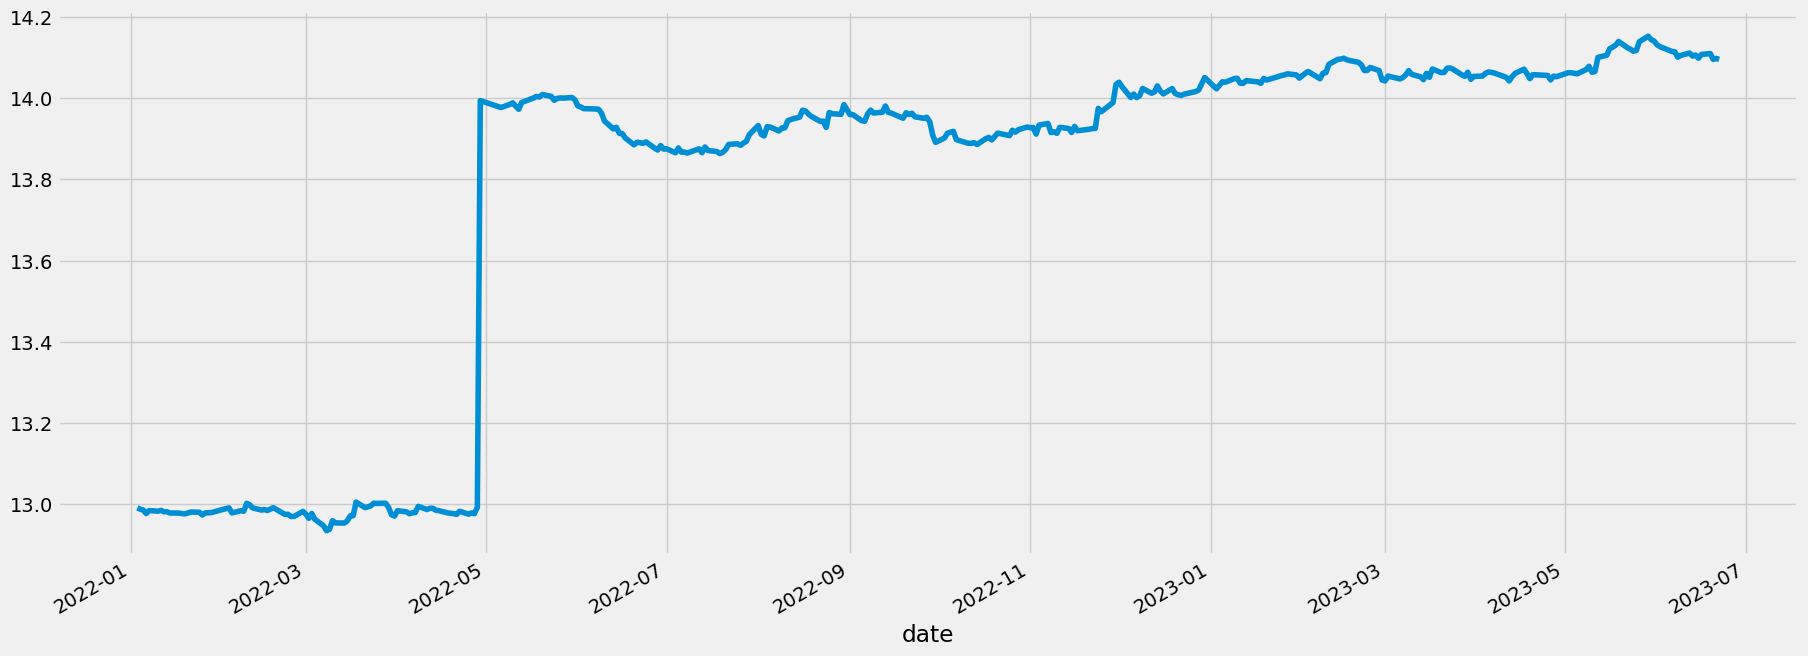

In [73]:
fig, ax1 = plt.subplots(figsize=(20,8))
tdf = df.pivot_table(values='cum_return',index='date', columns='id_bbg')
tdf['green_index'] = tdf.sum(axis=1)
tdf['green_index'].plot(ax=ax1)